In [1]:
import os
import sys
import argparse
import torch
from getdist import plots, MCSamples
import getdist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from scipy.stats import multivariate_normal

In [2]:
path = os.path.realpath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, path)

In [3]:
from nnest.trainer import Trainer

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# Himmelblau
#dims = 2
#def loglike(z):
#    z1 = z[:, 0]
#    z2 = z[:, 1]
#    return - (z1 ** 2 + z2 - 11.) ** 2 - (z1 + z2 ** 2 - 7.) ** 2
#def transform(x):
#    return 5. * x

In [6]:
# Rosenbrock
#dims = 2
#def loglike(z):
#    return np.array([-sum(100.0 * (x[1:] - x[:-1] ** 2.0) ** 2.0 + (1 - x[:-1]) ** 2.0) for x in z])
#def transform(x):
#    return 5. * x

In [7]:
# Gauss
dims = 2
corr = 0.9
def loglike(x):
    return multivariate_normal.logpdf(x, mean=np.zeros(dims), cov=np.eye(dims) + corr * (1 - np.eye(dims)))
def transform(x):
    return 3. * x

In [8]:
# Eggbox
#dims = 2
#def loglike(x):
#    chi = (np.cos(x[:,0] / 2.))*(np.cos(x[:,1] / 2.))
#    return (2. + chi)**5
#def transform(x):
#    return x * 5 * np.pi

In [9]:
n_samples = 1000
fraction = 0.02

In [10]:
np.random.seed(0)
x = 2 * (np.random.uniform(size=(int(n_samples / fraction), dims)) - 0.5)
likes = loglike(transform(x))
idx = np.argsort(-likes)
samples = x[idx[0:n_samples]]

In [11]:
t = Trainer(dims, flow='choleksy', learning_rate=0.001)
#t = Trainer(dims, hidden_dim=64,  num_blocks=5, flow='nvp')
#t = Trainer(dims, hidden_dim=16,  num_blocks=3, flow='spline')

[nnest.trainer] [INFO] SingleSpeedCholeksy(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): Choleksy()
    )
  )
)
[nnest.trainer] [INFO] Number of network params: [5]
[nnest.trainer] [INFO] Device [cpu]


In [12]:
t.train(samples, jitter=0.01)

[nnest.trainer] [INFO] Number of training samples [1000]
[nnest.trainer] [INFO] Training jitter [0.0100]
[nnest.trainer] [INFO] Epoch [1] train loss [0.0185] validation loss [0.0184]
[nnest.trainer] [INFO] Epoch [50] train loss [0.0134] validation loss [0.0133]
[nnest.trainer] [INFO] Epoch [100] train loss [0.0091] validation loss [0.0090]
[nnest.trainer] [INFO] Epoch [150] train loss [0.0055] validation loss [0.0054]
[nnest.trainer] [INFO] Epoch [200] train loss [0.0025] validation loss [0.0024]
[nnest.trainer] [INFO] Epoch [250] train loss [-0.0001] validation loss [-0.0003]
[nnest.trainer] [INFO] Epoch [300] train loss [-0.0024] validation loss [-0.0025]
[nnest.trainer] [INFO] Epoch [350] train loss [-0.0044] validation loss [-0.0045]
[nnest.trainer] [INFO] Epoch [400] train loss [-0.0061] validation loss [-0.0063]
[nnest.trainer] [INFO] Epoch [450] train loss [-0.0077] validation loss [-0.0079]
[nnest.trainer] [INFO] Epoch [500] train loss [-0.0091] validation loss [-0.0094]
[nnest

In [13]:
x_synth = t.netG.sample(samples.size).detach().cpu().numpy()
z = t.get_latent_samples(samples)

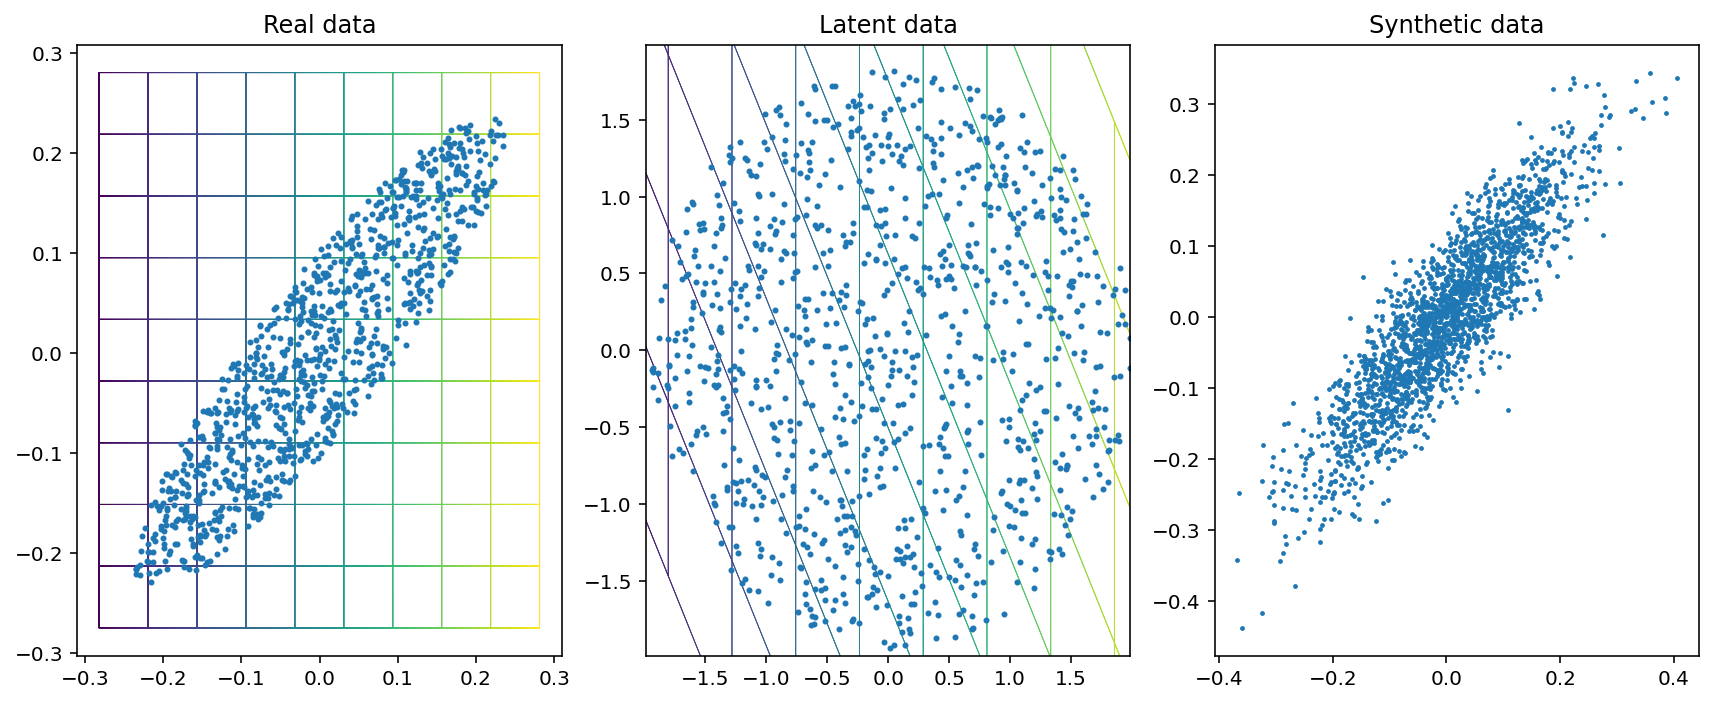

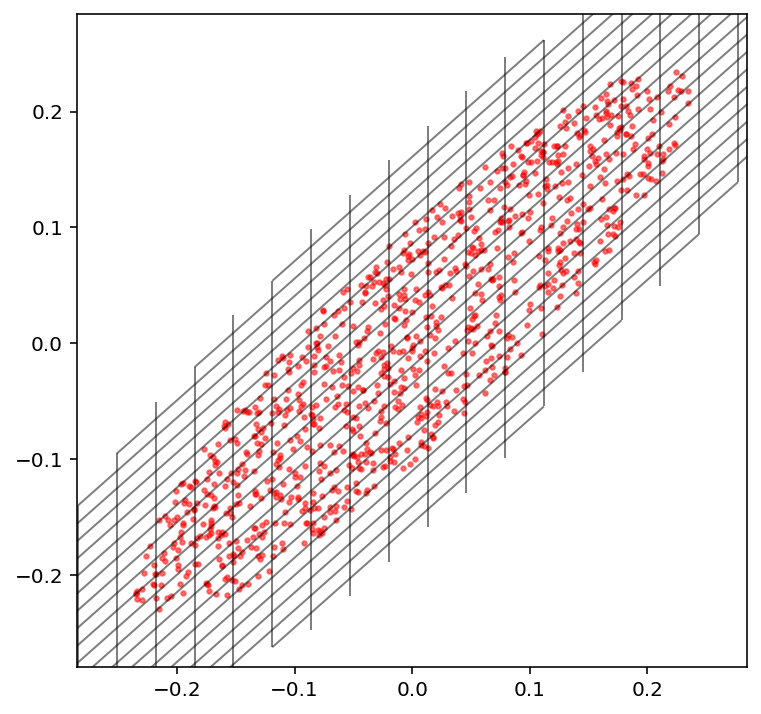

In [14]:
if dims == 2:
    grid = []
    for x in np.linspace(np.min(samples[:, 0])*1.2, np.max(samples[:, 0])*1.2, 10):
        for y in np.linspace(np.min(samples[:, 1])*1.2, np.max(samples[:, 1])*1.2, 5000):
            grid.append([x, y])
    for y in np.linspace(np.min(samples[:, 1])*1.2, np.max(samples[:, 1])*1.2, 10):
        for x in np.linspace(np.min(samples[:, 0])*1.2, np.max(samples[:, 0])*1.2, 5000):
            grid.append([x, y])
    grid = np.array(grid)
    z_grid = t.get_latent_samples(grid)
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    ax[0].scatter(grid[:, 0], grid[:, 1], c=grid[:, 0], marker='.', s=1, linewidths=0)
    ax[0].scatter(samples[:, 0], samples[:, 1], s=4)
    ax[0].set_title('Real data')
    ax[1].scatter(z_grid[:, 0], z_grid[:, 1], c=grid[:, 0], marker='.', s=1, linewidths=0)
    ax[1].scatter(z[:, 0], z[:, 1], s=4)
    ax[1].set_title('Latent data')
    ax[1].set_xlim([-np.max(np.abs(z)), np.max(np.abs(z))])
    ax[1].set_ylim([-np.max(np.abs(z)), np.max(np.abs(z))])
    ax[2].scatter(x_synth[:, 0], x_synth[:, 1], s=2)
    ax[2].set_title('Synthetic data')
    plt.tight_layout()
    plt.show()
    # Plot grid warp
    plt.figure(figsize=(6,6))
    ng = 30
    xx, yy = np.linspace(-4,4, ng), np.linspace(-4,4, ng)
    xv, yv = np.meshgrid(xx, yy)
    xy = np.stack([xv, yv], axis=-1)
    in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3
    xy = xy.reshape((ng*ng, 2))
    xy = torch.from_numpy(xy.astype(np.float32))
    xs = t.get_samples(xy)
    xs = xs.reshape((ng, ng, 2))
    p1 = np.reshape(xs[1:,:,:], (ng**2-ng,2))
    p2 = np.reshape(xs[:-1,:,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    p1 = np.reshape(xs[:,1:,:], (ng**2-ng,2))
    p2 = np.reshape(xs[:,:-1,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    plt.gca().add_collection(lcy)
    plt.gca().add_collection(lcx)
    plt.xlim([np.min(samples[:,0])-0.05,np.max(samples[:,0])+0.05])
    plt.ylim([np.min(samples[:,1])-0.05,np.max(samples[:,1])+0.05])
    plt.scatter(samples[:,0], samples[:,1], c='r', s=5, alpha=0.5)
    plt.show()